In [1]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('sushan_daily_updated.csv')

In [3]:
mask = df['symbol'].str.contains('BA')

In [4]:
df['20days_GM'] = None
df['20days_AM'] = None

In [5]:
df.loc[mask,'20days_GM'] = df[mask]['total_vol'].rolling(20).apply(np.prod, raw=True)

In [6]:
df.loc[mask,'20days_GM'] = df.loc[mask,'20days_GM'] ** (1/20)
df.loc[mask,'20days_GM'] = df.loc[mask,'20days_GM'].apply(lambda x: round(x,1) if str(x) != '<NA>' else x)
df.loc[mask,'20days_AM'] = df[mask]['total_vol'].rolling(20).mean()

In [7]:
df[mask]

,Unnamed: 0,DATE,SYM_ROOT,total_vol,symbol,CSize,CPrc,OPrc,total_vol_m,total_vol_b,total_vol_a,Ovn_Gap,20days_GM,20days_AM
0,0,2018/12/31,BA,3000834,BA,331313,322.50,320.50,3333107,17615.0,222859.0,NaN,NaN,NaN
11,11,2019/01/02,BA,2615881,BA,344277,323.81,315.51,2960345,29263.0,303300.0,-6.99,NaN,NaN
12,12,2019/01/03,BA,4930361,BA,326533,310.90,318.53,5255368,31021.0,431490.0,-5.28,NaN,NaN
13,13,2019/01/04,BA,3674863,BA,463794,327.08,316.69,4139757,42039.0,288650.0,5.79,NaN,NaN
14,14,2019/01/07,BA,3064577,BA,359758,328.11,330.30,3422972,24279.0,583696.0,3.22,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5804,5804,2021/12/27,BA,7271163,BA,253331,203.17,201.96,7523713,95126.0,208367.0,-2.26,9153487.4,9525519.4
5805,5805,2021/12/28,BA,8333741,BA,240289,206.13,202.23,8574671,62362.0,256928.0,-0.94,9005964.3,9365523.3
5806,5806,2021/12/29,BA,5645408,BA,240570,203.66,205.05,5886519,47561.0,188310.0,-1.08,8711782.6,9099353.6
5807,5807,2021/12/30,BA,6693702,BA,159322,202.71,203.00,6854595,49387.0,110237.0,-0.66,8444875.5,8810430.3


<AxesSubplot:xlabel='DATE'>

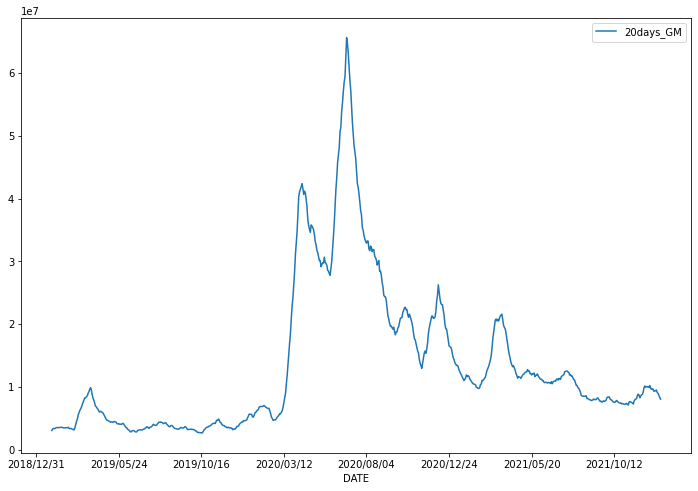

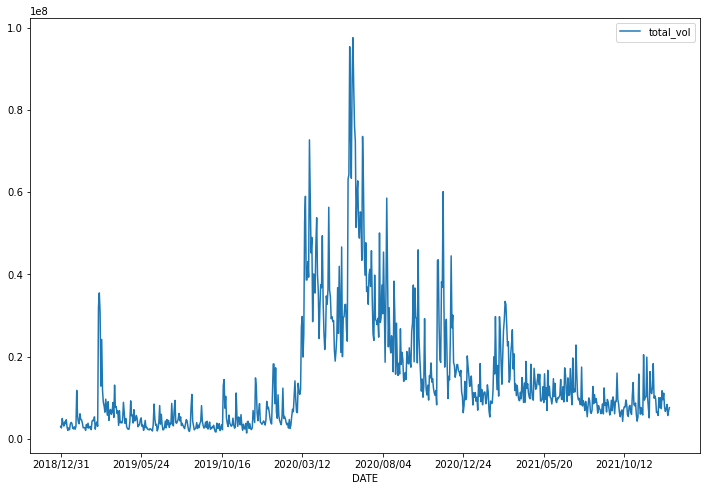

In [8]:
df[mask].plot(figsize = (12,8), x = 'DATE', y = '20days_GM')
df[mask].plot(figsize = (12,8), x = 'DATE', y = 'total_vol')

In [9]:
# to get the d part
result = adfuller(df[mask].total_vol.dropna())
print('ADF Statistic: %f' % result[0])
# The more negative it is, the stronger the rejection of the hypothesis that 
# there is a unit root at some level of confidence.
print('p-value: %f' % result[1])

ADF Statistic: -3.007106
p-value: 0.034236


In [26]:
!pip install pmdarima

     |████████████████████████████████| 595 kB 6.3 MB/s eta 0:00:01


In [27]:
from pmdarima.arima.utils import ndiffs #package for getting number differencing time to be stationary 

In [29]:
ndiffs(df[mask].total_vol, test = 'adf') #so 1 differencing we will have stationary cuve

1

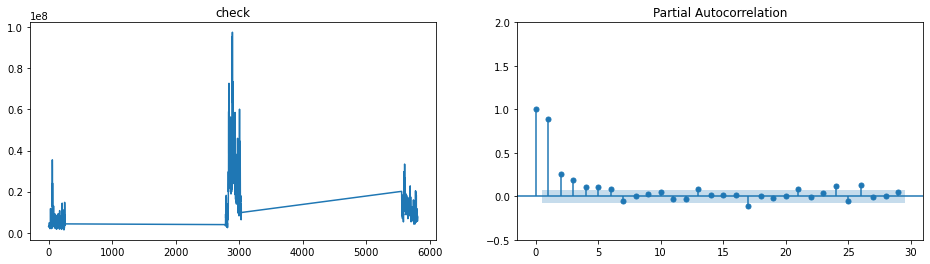

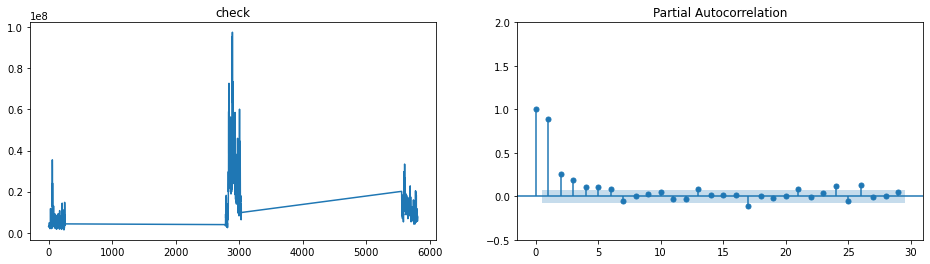

In [49]:
#to get the p part
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# if need to be differencing first, diff = df[mask].total_vol.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 4))
ax1.plot(df[mask]['total_vol'])
ax1.set_title('check')
ax2.set_ylim(-0.5,2)
plot_pacf(df[mask]['total_vol'], ax=ax2)

#it seems at 1, (ignore the zero) has the highest correctness. 

In [ ]:
#to get q at ARMA(p,d,q), order of the moving average

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [16]:
df[mask]['total_vol'].describe()

count    7.570000e+02
mean     1.439676e+07
std      1.459516e+07
min      1.381812e+06
25%      4.576026e+06
50%      9.403553e+06
75%      1.806955e+07
max      9.756495e+07
Name: total_vol, dtype: float64

In [17]:
n = int(len(df[mask]) * 0.8) #set up training data + testing data
n

605

In [55]:
#train = df[mask].total_vol[:n]
train = df[mask][:n]
#test = df[mask].total_vol[n:]
test = df[mask][n:]

In [56]:
from statsmodels.tsa.arima_model import ARIMA

# AR = 1, MR = 1 ARIMA Model
model = ARIMA(train.total_vol, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
#by def: keep value which p-value and coef close to zero

                              ARMA Model Results                              
Dep. Variable:              total_vol   No. Observations:                  605
Model:                     ARMA(1, 1)   Log Likelihood              -10392.859
Method:                       css-mle   S.D. of innovations        6975100.227
Date:                Wed, 26 Jan 2022   AIC                          20793.718
Time:                        12:33:36   BIC                          20811.339
Sample:                             0   HQIC                         20800.575
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.562e+07   4.34e+06      3.602      0.000    7.12e+06    2.41e+07
ar.L1.total_vol     0.9633      0.012     79.826      0.000       0.940       0.987
ma.L1.total_vol    -0.4168      

/Users/zss/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/zss/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be 

(array([1.87744708e-09, 6.97337488e-09, 3.59397013e-08, 9.09220801e-08,
        1.63606103e-08, 4.29130762e-09, 2.41386053e-09, 1.87744708e-09,
        1.07282690e-09, 5.36413452e-10]),
 array([-20954450.88941034, -14791695.0676196 ,  -8628939.24582885,
         -2466183.4240381 ,   3696572.39775265,   9859328.21954339,
         16022084.04133414,  22184839.86312489,  28347595.68491564,
         34510351.50670639,  40673107.32849713]),
 <BarContainer object of 10 artists>)

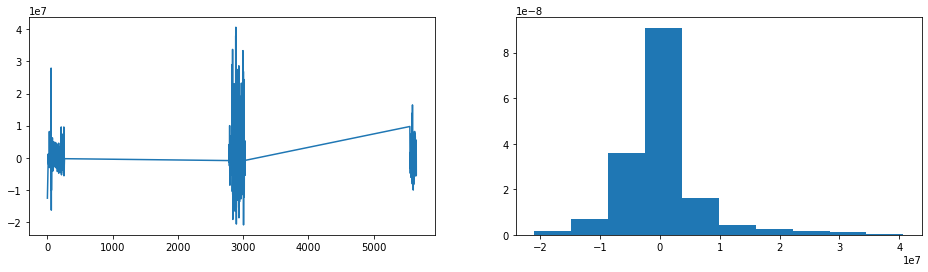

In [63]:
#plot residual erros
residuals = pd.DataFrame(model_fit.resid)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4))
ax1.plot(residuals)
ax2.hist(residuals, density = True)

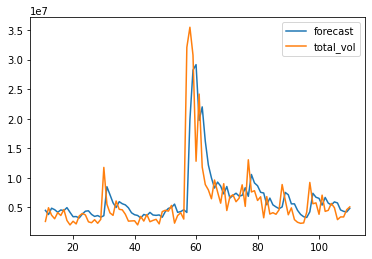

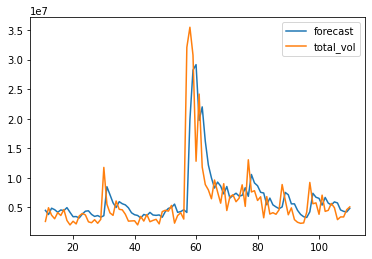

In [66]:
#actual vc fitted
model_fit.plot_predict(start = 1, end = 100, dynamic = False)

In [51]:
step = 30 #forcast

fc, se, conf = model_fit.forecast(step)

In [52]:
fc #array of out of sample forecasts, se means standard error, conf menas confidence interval

array([ 9387114.36815344,  9615593.45879055,  9835697.00965991,
       10047732.04958506, 10251994.35238973, 10448768.84948131,
       10638330.02730997, 10820942.31025771, 10996860.42949164,
       11166329.77829584, 11329586.75437759, 11486859.08962537,
       11638366.16777868, 11784319.33045276, 11924922.17194517,
       12060370.82323535, 12190854.22557339, 12316554.39403973,
       12437646.67144318, 12554299.97291176, 12666677.02151727,
       12774934.57526242, 12879223.64574714, 12979689.70881902,
       13076472.90750177, 13169708.24748482, 13259525.78544664,
       13346050.81047459, 13429404.01883431, 13509701.68233239])

In [53]:
fc = pd.Series(fc, index = test[:step].index)
lower = pd.Series(conf[:, 0], index = test[:step].index)
upper = pd.Series(conf[:, 1], index = test[:step].index)

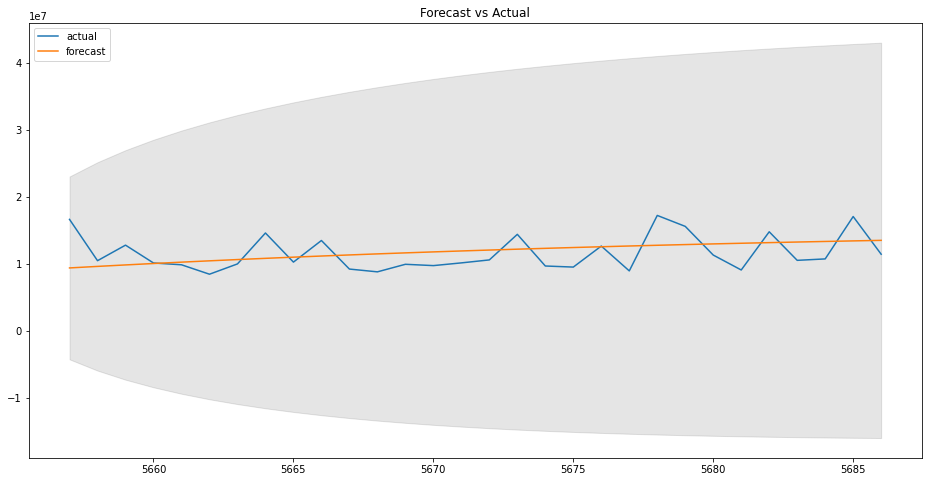

In [59]:
plt.figure(figsize=(16, 8))
plt.plot(test.total_vol[:step], label = 'actual')
plt.plot(fc, label = 'forecast')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.1)
plt.title("Forecast vs Actual")
plt.legend(loc = "upper left")

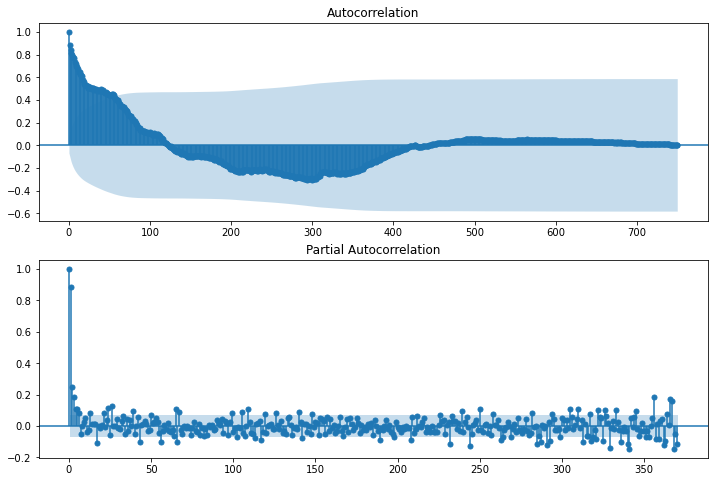

In [340]:
#Original Series AR
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf((df[mask]['total_vol']/1000000).squeeze(), lags=750, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf((df[mask]['total_vol']/1000000), lags=370, ax=ax2)

In [149]:
from sklearn.linear_model import LinearRegression

In [222]:
filter_df = df[mask][df[mask].total_vol > 9329405]

In [249]:
X = abs(filter_df['Ovn_Gap']).iloc[3:].values.reshape(-1, 1)

In [250]:
filter_df['excess_vol'] = np.log(filter_df['total_vol'] - 9329405)

In [225]:
#filter_df['volatility_ratio'] = TTR/ ATR , need addtional data Beta for volatility 

,Unnamed: 0,DATE,SYM_ROOT,total_vol,symbol,CSize,CPrc,OPrc,total_vol_m,total_vol_b,total_vol_a,Ovn_Gap,20days_GM,20days_AM,excess_vol
30,30,2019/01/30,BA,11755060,BA,195467,387.72,387.40,11950792,548589.0,208628.0,22.49,2.471546,3616953.45,14.701612
57,57,2019/03/11,BA,32067146,BA,276042,400.01,371.27,32343199,2156135.0,243102.0,-51.27,2.504222,4703573.1,16.939537
58,58,2019/03/12,BA,35472235,BA,287277,375.41,384.71,35756330,639188.0,534789.0,-15.30,2.541968,6344099.45,17.079086
59,59,2019/03/13,BA,30758200,BA,416916,377.14,378.02,31175754,783594.0,703165.0,2.61,2.567489,7747170.0,16.880246
60,60,2019/03/14,BA,12799504,BA,271909,373.30,374.99,13071639,286336.0,164529.0,-2.15,2.57559,8250989.45,15.059694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5795,5795,2021/12/13,BA,9980081,BA,425978,197.40,202.68,10406220,67672.0,151596.0,-2.38,2.613174,11023963.3,13.385767
5797,5797,2021/12/15,BA,9983937,BA,382892,195.43,195.00,10367213,64527.0,104701.0,-0.50,2.605706,10410652.95,13.391676
5799,5799,2021/12/17,BA,11673658,BA,990360,192.63,190.60,12663367,103609.0,483872.0,-0.19,2.604886,10345318.25,14.667477
5800,5800,2021/12/20,BA,9482173,BA,489641,188.48,188.00,9971705,157273.0,127959.0,-4.63,2.598199,9826926.25,11.936676


In [252]:
linear_regressor = LinearRegression()
linear_regressor.fit(Y, X)  # perform linear regression
volume_prediction = linear_regressor.predict(Y)

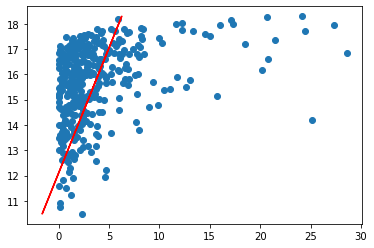

In [257]:
plt.scatter(X, Y)
plt.plot(volume_prediction, Y, color='red')
plt.show()